## Seasonal Cash Price Live Cattle

- Deep dive analysis on the monthly cash price received for live cattle
- Ran some regressions to understand seasonality patterns and investigate how well price can be predicted solely on past price movement

In [51]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../')
import src

import warnings
warnings.filterwarnings('ignore')

In [52]:
price_received_ge_500_national = pd.read_csv('../csv/price_received_ge_500_national.csv')

price_received_ge_500_national = src.usda_clean_monthly(price_received_ge_500_national, historical=True)

price_received_ge_500_national_pct_chg = price_received_ge_500_national.pct_change()*100
price_received_ge_500_national_pct_chg.name = 'price_received_ge_500_national_pct_chg'
price_received_ge_500_national_pct_chg.dropna(inplace=True)

price_received_ge_500_national_adj = src.adjust_series_cpi(price_received_ge_500_national)
price_received_ge_500_national_adj.name = 'price_received_ge_500_national_adj'

- From previous analysis found that cash price tracks live cattle futures contract price extremely closely (See this [notebook](../futures_cash_price_analysis.ipynb))
    - Regressing these two variables gives coefficeint of ~1, with p-value ~0, and R-squared ~99.8%

In [53]:
df_adj = pd.DataFrame({
    'price_received_ge_500_national_adj':price_received_ge_500_national_adj,
    'month' : price_received_ge_500_national_adj.index.month,
    'quarter' : price_received_ge_500_national_adj.index.quarter,
})

import plotly.subplots as sp

fig = sp.make_subplots(rows=1, cols=1)

fig.add_box(y=df_adj['price_received_ge_500_national_adj'], x=df_adj['month'], name='Price Received')

fig.update_layout(title='Price Received for GE 500 by Month (Adj. CPI)',
                  xaxis_title='Month',
                  yaxis_title='Adjusted Price Received')

fig.show()

Text(0.5, 1.0, 'Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

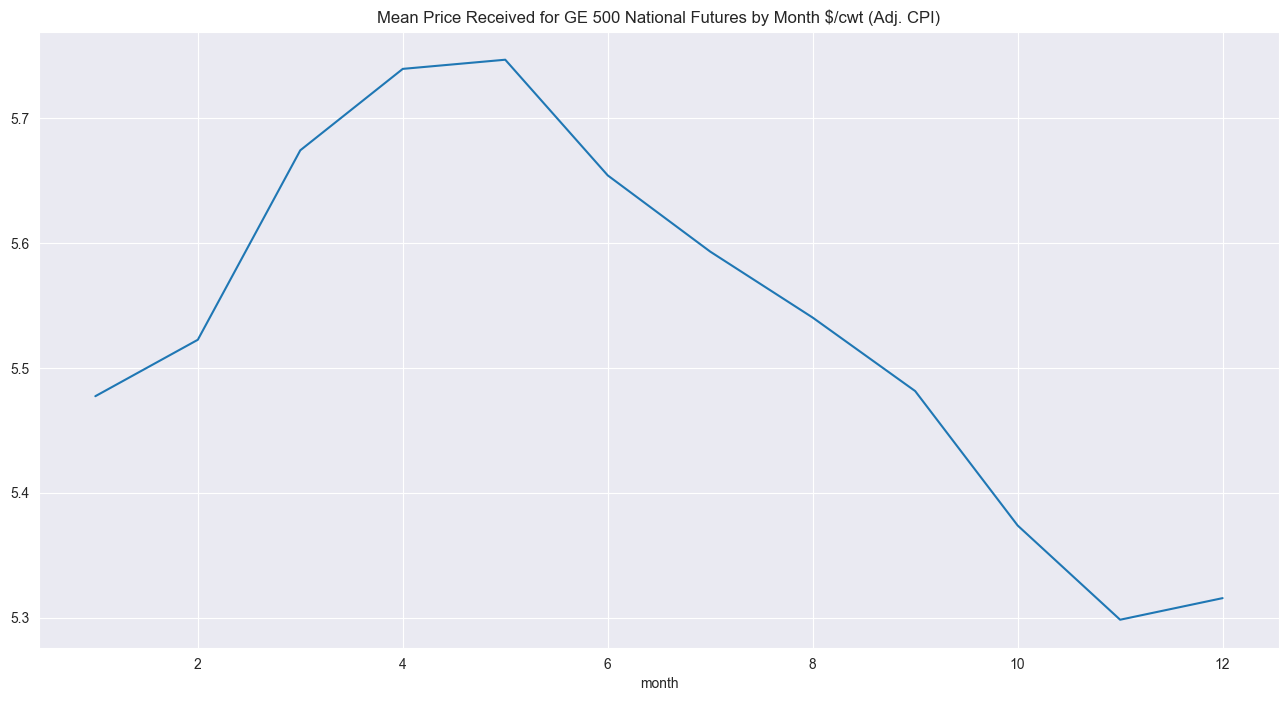

In [54]:
df_adj.groupby('month')['price_received_ge_500_national_adj'].mean().plot()
plt.title('Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

- Cash price is higher throughout the first half of the year (max in May) and lower during second half of the year (min in October)
- Price variance also higher during first half of the year

### Regressing using one lag

In [55]:
import statsmodels.api as sm


X = price_received_ge_500_national_pct_chg.shift(1).dropna()
X.name = 'price_received_ge_500_national_pct_chg_lag_1'
X = sm.add_constant(X)

y = price_received_ge_500_national_pct_chg[X.index]

model = sm.OLS(y, X).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.034
Model:                                                OLS   Adj. R-squared:                  0.033
Method:                                     Least Squares   F-statistic:                     47.31
Date:                                    Mon, 18 Sep 2023   Prob (F-statistic):           9.18e-12
Time:                                            00:07:05   Log-Likelihood:                -3876.7
No. Observations:                                    1365   AIC:                             7757.
Df Residuals:                                        1363   BIC:                             7768.
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

- Since we are not adjusting for inflation, we expected a positive constant
- Lag of one month is highly significant with coefficient of 0.18
- R-squared extremely low

#### Regressing using 12 lags

In [56]:
import statsmodels.api as sm
import pandas as pd

lags = 12
for i in range(1, lags+1):
    
    price_received_ge_500_national_pct_chg_lag = price_received_ge_500_national.pct_change().shift(i)*100
    price_received_ge_500_national_pct_chg_lag.name = f'price_received_ge_500_national_pct_chg_lag_{i}'

    if i == 1:
        X_lags = price_received_ge_500_national_pct_chg_lag.dropna()
    else:
        X_lags = pd.concat([X_lags, price_received_ge_500_national_pct_chg_lag], axis=1)

In [57]:
X_lags = X_lags.dropna()
X_lags = sm.add_constant(X_lags)

y = price_received_ge_500_national_pct_chg[X_lags.index]

model = sm.OLS(y, X_lags).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.120
Model:                                                OLS   Adj. R-squared:                  0.112
Method:                                     Least Squares   F-statistic:                     15.23
Date:                                    Mon, 18 Sep 2023   Prob (F-statistic):           1.90e-30
Time:                                            00:07:05   Log-Likelihood:                -3780.2
No. Observations:                                    1354   AIC:                             7586.
Df Residuals:                                        1341   BIC:                             7654.
Df Model:                                              12                                         
Covariance Type:                                nonrobust                                         
          

- Lagged coefficients are capturing the cyclicality of cash price
- R-squared increased to 0.12 leaving much variance still unexplained

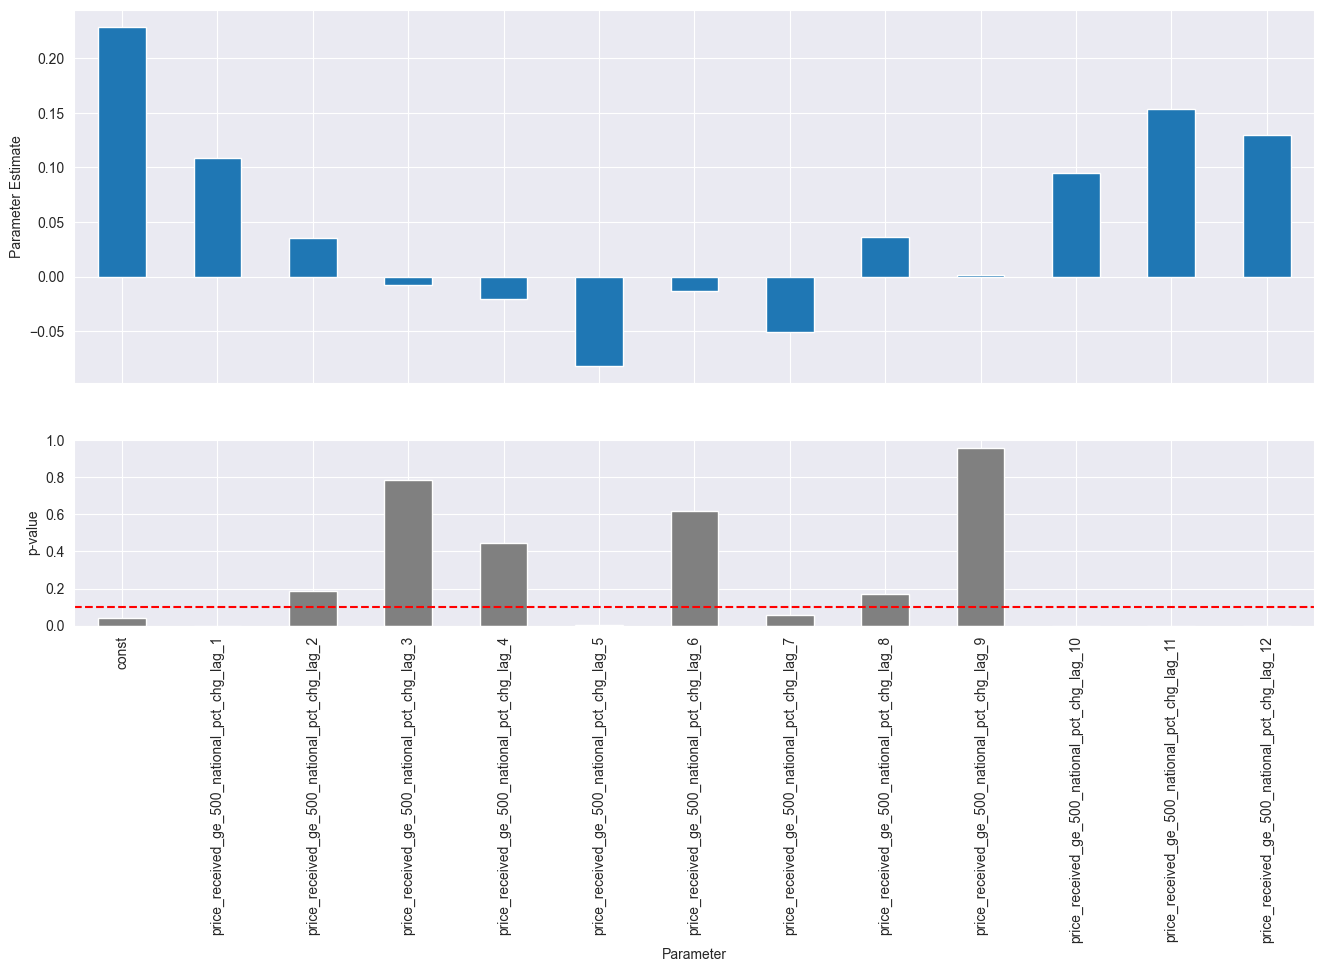

In [58]:
src.plot_coefficients_pvalues(model)

### Regressing with monthly indicator variables

In [59]:
X_seasonal = pd.get_dummies(price_received_ge_500_national_pct_chg.index.month).astype(int)
X_seasonal.columns = [ f'month_{i}' for i in X_seasonal.columns]
X_seasonal.index = price_received_ge_500_national_pct_chg.index
# X_seasonal = sm.add_constant(X_seasonal)

y = price_received_ge_500_national_pct_chg

model = sm.OLS(y, X_seasonal.loc[y.index, :]).fit()
print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.128
Model:                                                OLS   Adj. R-squared:                  0.121
Method:                                     Least Squares   F-statistic:                     18.05
Date:                                    Mon, 18 Sep 2023   Prob (F-statistic):           6.11e-34
Time:                                            00:07:06   Log-Likelihood:                -3808.9
No. Observations:                                    1366   AIC:                             7642.
Df Residuals:                                        1354   BIC:                             7704.
Df Model:                                              11                                         
Covariance Type:                                nonrobust                                         
          

Text(0.5, 1.0, 'Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

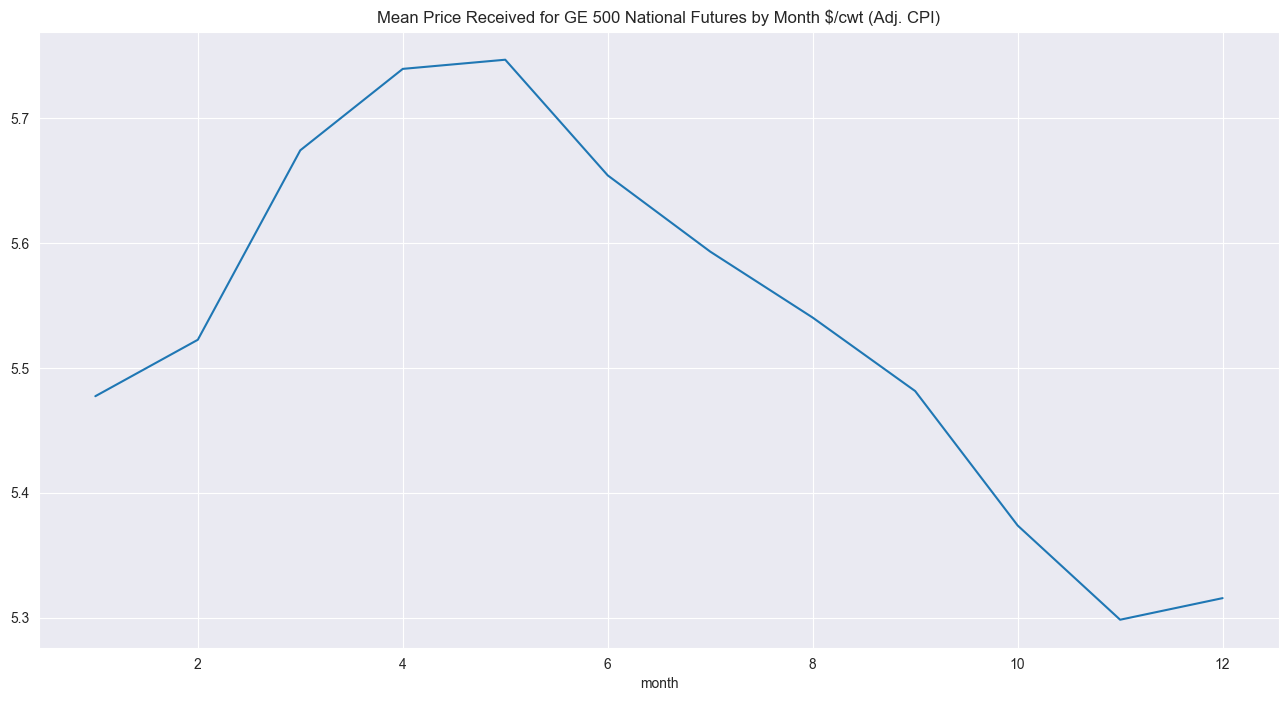

In [60]:
df_adj.groupby('month')['price_received_ge_500_national_adj'].mean().plot()
plt.title('Mean Price Received for GE 500 National Futures by Month $/cwt (Adj. CPI)')

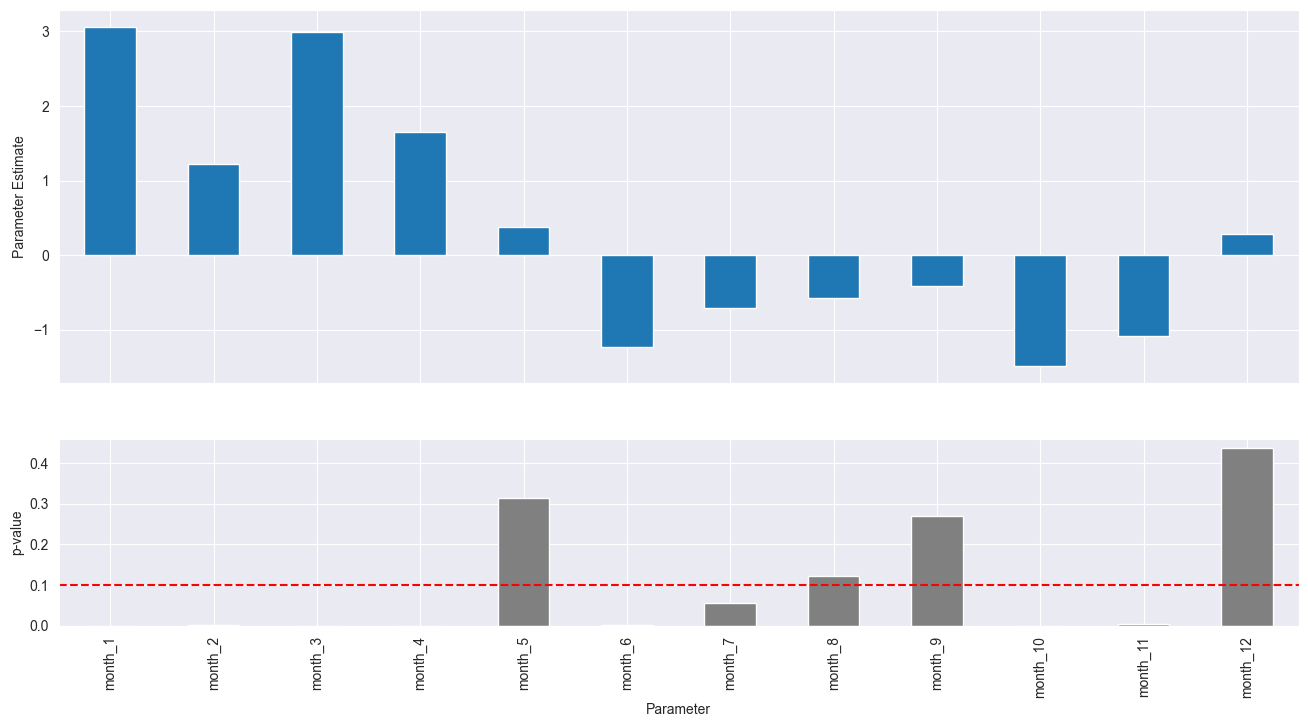

In [61]:
src.plot_coefficients_pvalues(model)

- Coefficients match with price cyclicality as expected
- Price appreciation generally occuring from December to April, with sharpest increase in January
- June is expected to experience sharpest drop

### Regressing with 12 lags and monthly inidicator variables

In [62]:
X_lags_seasonal = pd.concat([X_lags, X_seasonal], axis=1)
X_lags_seasonal = X_lags_seasonal.dropna()
X_lags_seasonal = sm.add_constant(X_lags_seasonal)

y = price_received_ge_500_national_pct_chg[X_lags_seasonal.index]
y = y.dropna()
y.name = 'price_received_ge_500_national_pct_chg'

model = sm.OLS(y, X_lags_seasonal.loc[y.index, :]).fit()

print(model.summary())

                                      OLS Regression Results                                      
Dep. Variable:     price_received_ge_500_national_pct_chg   R-squared:                       0.186
Model:                                                OLS   Adj. R-squared:                  0.172
Method:                                     Least Squares   F-statistic:                     13.23
Date:                                    Mon, 18 Sep 2023   Prob (F-statistic):           3.02e-45
Time:                                            00:07:06   Log-Likelihood:                -3727.3
No. Observations:                                    1354   AIC:                             7503.
Df Residuals:                                        1330   BIC:                             7628.
Df Model:                                              23                                         
Covariance Type:                                nonrobust                                         
          

- R-squared slightly lower than with only indicator variables

## Testing various models

- Test various models to determine how well price can be predicted using historical price data alone
- Used scikit-learn TimeSeriesSplit class to train and test on separate datasets and record the performance on each test fold
- Since we are predicting on a percentage level, mean absolute error tells us how many percentage points our prediction was 'off' in terms of magnitude (e.g. if we predict +3%, but realised is -1% this will contribute 4% to our mean absolute error. The final MAE will be the mean over each prediction's error)

##### Models Tested
 - Naive model
 - Seasonal Indicator Variable Model (Regression)
 - Seasonal Indicator Variable and Lagged Model (Regression)
 - XGBoost
 - Facebook Prophet

### Naive Model

The Naive model simply predicts the %∆ in cash price across months is 0. Therefore any deviation from this is an 'error'

In [63]:
errors_naive_model = list(price_received_ge_500_national_pct_chg.dropna())

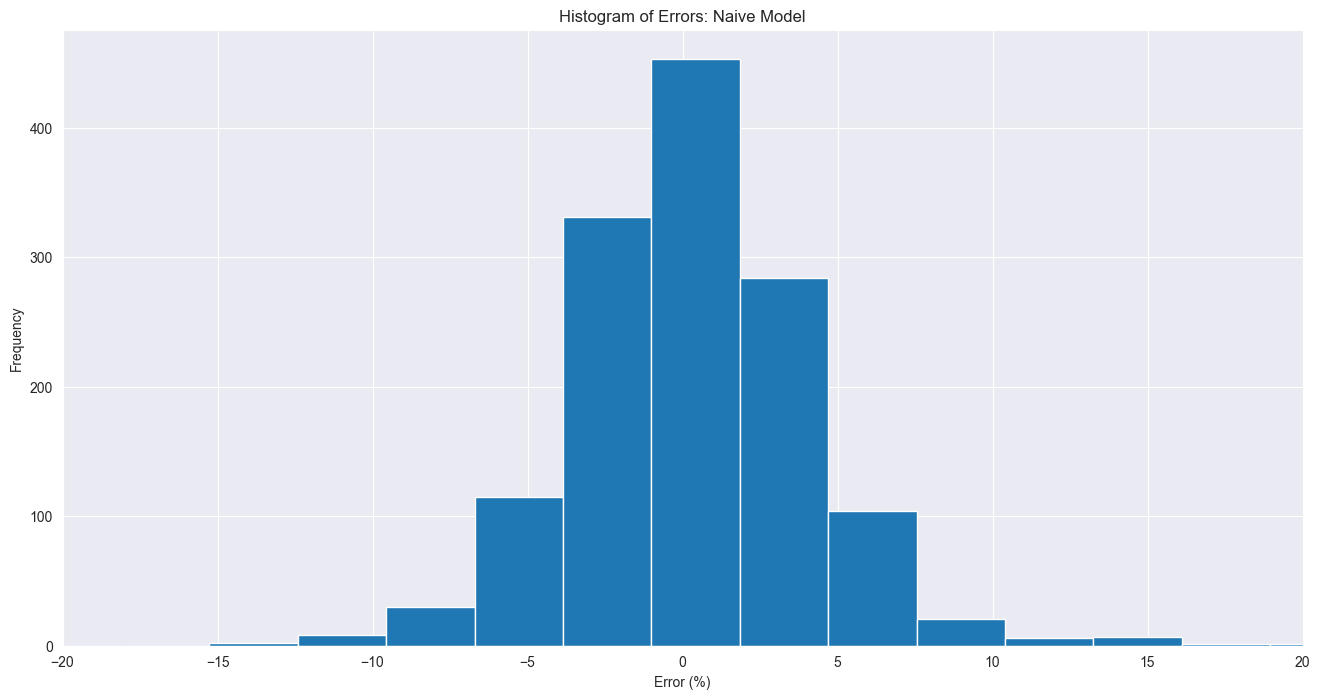

Mean absolute error of Naive Model: 2.96 %
Percentage of months closing up: 51.76%


In [64]:
model_name = 'Naive Model'
errors = errors_naive_model


plt.hist(errors, bins=30)
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Errors: {model_name}')
plt.xlim(-20, 20)
plt.show()

print(f'Mean absolute error of {model_name}: {round(np.mean(abs(pd.Series(errors))),2)} %')
print(f'Percentage of months closing up: {np.mean([1 if i > 0 else 0 for i in price_received_ge_500_national_pct_chg])*100:.2f}%')

### Monthly Indicator Variable Model (Regression)

In [65]:
from sklearn.model_selection import TimeSeriesSplit

y = price_received_ge_500_national_pct_chg
y = y.dropna()

df_seasonal_model = pd.concat([y, X_seasonal], axis=1)
df_seasonal_model = df_seasonal_model.dropna()

tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(df_seasonal_model)/10))

In [66]:
errors_seasonal_model = []
errors_seasonal_model_directional = []

for train_index, test_index in tscv.split(df_seasonal_model):

    train_data, test_data = df_seasonal_model.iloc[train_index], df_seasonal_model.iloc[test_index]

    model = sm.OLS(
        train_data['price_received_ge_500_national_pct_chg'],
        train_data.drop('price_received_ge_500_national_pct_chg', axis=1)
    ).fit()

    y_actual = test_data['price_received_ge_500_national_pct_chg']
    y_pred = model.predict(test_data.drop('price_received_ge_500_national_pct_chg', axis=1))

    errors_seasonal_model.extend(y_pred - y_actual)
    
    errors_seasonal_model_directional.extend(
        [1 if i > 0 else 0 for i in y_pred*y_actual]
    )

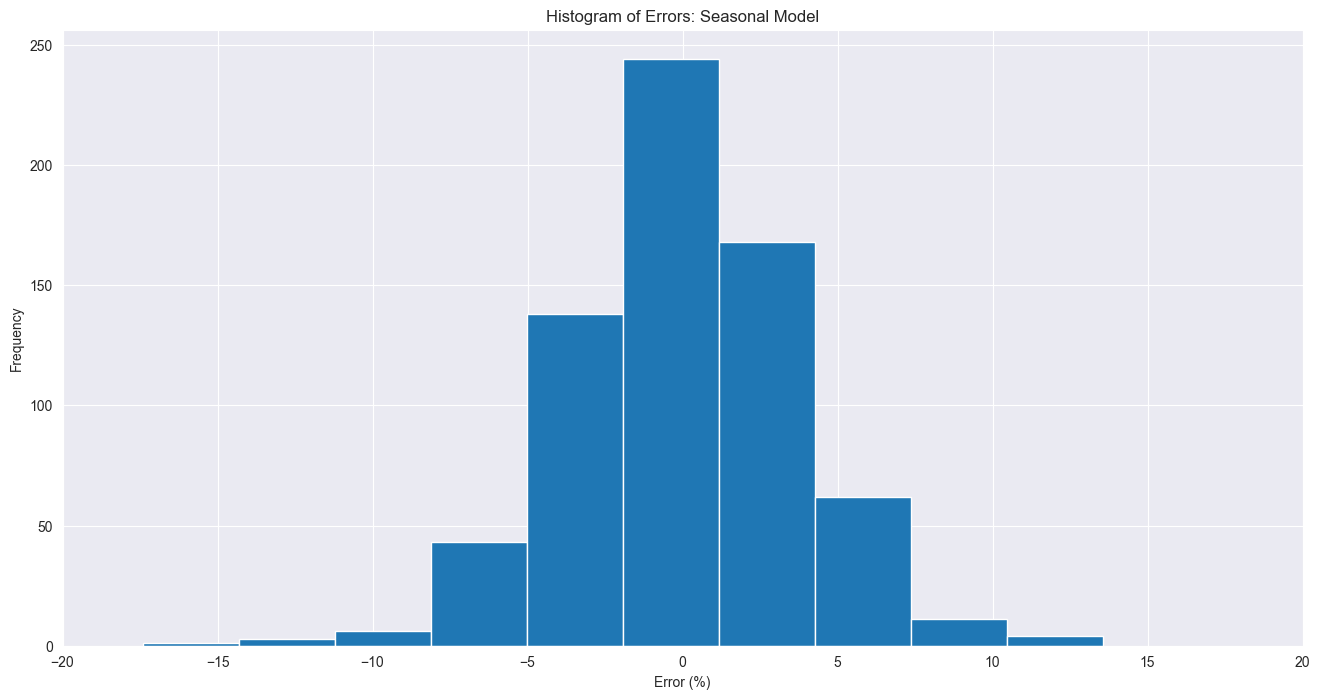

Mean absolute error of Seasonal Model: 2.76 %
Correct directional forecast Seasonal Model: 57.50%


In [67]:
model_name = 'Seasonal Model'
errors = errors_seasonal_model
errors_directional = errors_seasonal_model_directional

####

plt.hist(errors)
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Errors: {model_name}')
plt.xlim(-20, 20)
plt.show()

print(f'Mean absolute error of {model_name}: {round(np.mean(abs(pd.Series(errors))),2)} %')
print(f'Correct directional forecast {model_name}: {np.mean([1 if i > 0 else 0 for i in errors_directional])*100:.2f}%')

- Regression with monthly indicator variables imrpoved MAE by 0.2% and correctly forecasted the direction 57.5% on the testing dataset

### Monthly Indicator Variable and Lagged Model (Regression)

In [68]:
import statsmodels.api as sm
import pandas as pd

df_seasonal_lags_model = pd.concat([y, X_seasonal, X_lags], axis=1)
df_seasonal_lags_model = df_seasonal_lags_model.dropna()

tscv = TimeSeriesSplit(n_splits=5, test_size=int(len(df_seasonal_lags_model)/10))

In [69]:
errors_seasonal_lags_model = []
errors_seasonal_lags_model_directional = []

for train_index, test_index in tscv.split(df_seasonal_lags_model):

    train_data, test_data = df_seasonal_lags_model.iloc[train_index], df_seasonal_lags_model.iloc[test_index]

    model = sm.OLS(
        train_data['price_received_ge_500_national_pct_chg'],
        train_data.drop('price_received_ge_500_national_pct_chg', axis=1)
    ).fit()

    y_pred = model.predict(test_data.drop('price_received_ge_500_national_pct_chg', axis=1))
    y_true = test_data['price_received_ge_500_national_pct_chg']

    errors_seasonal_lags_model.extend(y_pred - y_true)
    
    errors_seasonal_lags_model_directional.extend(
        [1 if i > 0 else 0 for i in y_true*y_pred]
    )

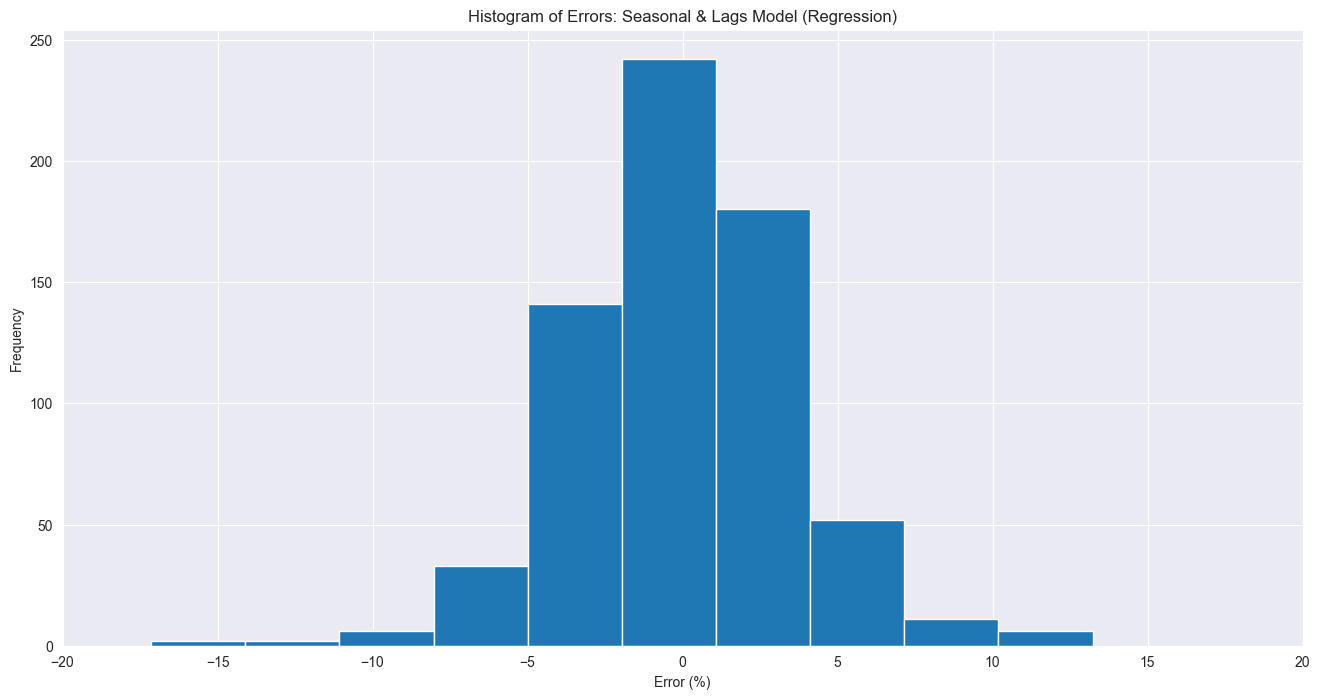

Mean absolute error of Seasonal & Lags Model (Regression): 2.68 %
Correct directional forecast Seasonal & Lags Model (Regression): 60.00%


In [70]:
import matplotlib.pyplot as plt

model_name = 'Seasonal & Lags Model (Regression)'
errors = errors_seasonal_lags_model
errors_directional = errors_seasonal_lags_model_directional

####

plt.hist(errors)
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Errors: {model_name}')
plt.xlim(-20, 20)
plt.show()

print(f'Mean absolute error of {model_name}: {round(np.mean(abs(pd.Series(errors))),2)} %')
print(f'Correct directional forecast {model_name}: {np.mean([1 if i > 0 else 0 for i in errors_directional])*100:.2f}%')

- Improved MAE and directional forecasting compared to regression with monthly indicator variables only

### XGBoost

In [71]:
import pandas as pd
import numpy as np
import xgboost as xgb

# set the XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

errors_seasonal_lags_model = []
errors_seasonal_lags_model_directional = []

for train_index, test_index in tscv.split(df_seasonal_lags_model):

    train_data, test_data = df_seasonal_lags_model.iloc[train_index], df_seasonal_lags_model.iloc[test_index]

    model = xgb.XGBRegressor(objective='reg:linear')

    model.fit(
        train_data.drop('price_received_ge_500_national_pct_chg', axis=1),
        train_data['price_received_ge_500_national_pct_chg']
    )


    y_true = test_data['price_received_ge_500_national_pct_chg']
    y_pred = model.predict(test_data.drop('price_received_ge_500_national_pct_chg', axis=1),)
    

    errors_seasonal_lags_model.extend(y_pred - y_true)
    
    errors_seasonal_lags_model_directional.extend(
        [1 if i > 0 else 0 for i in y_true*y_pred]
    )

[00:07:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[00:07:08] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regress

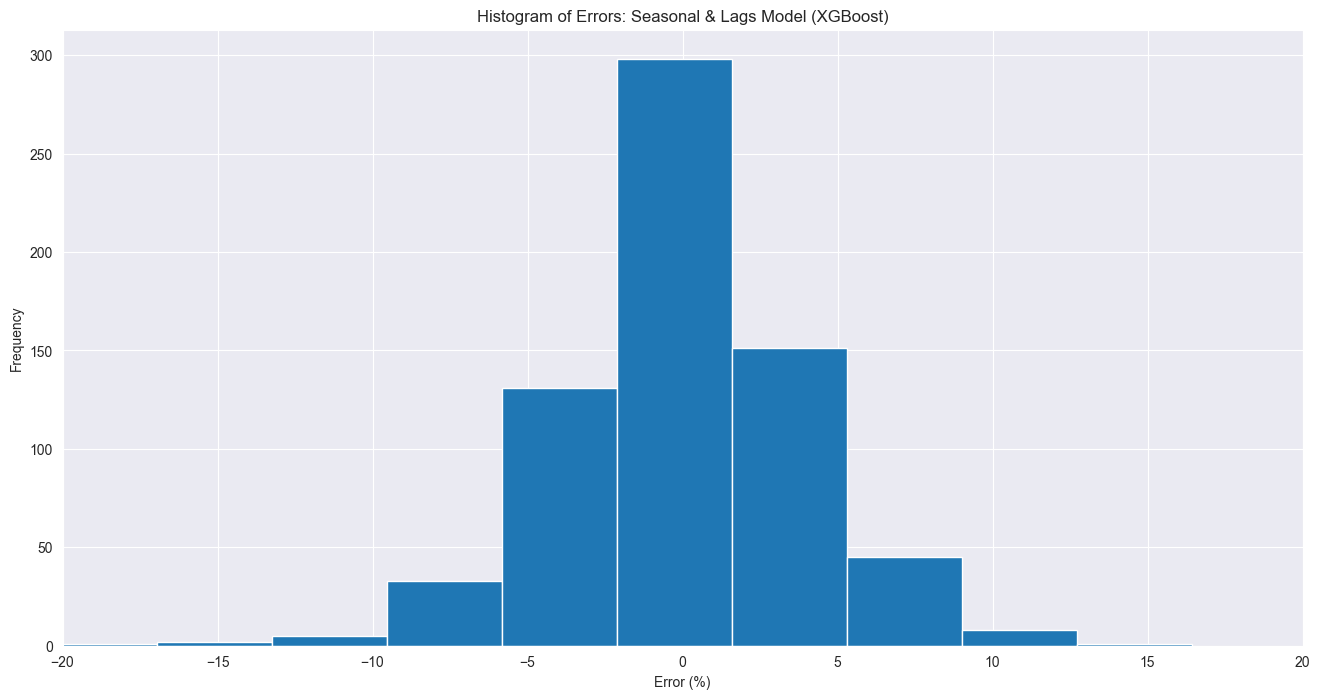

Mean absolute error of Seasonal & Lags Model (XGBoost): 2.86 %
Correct directional forecast Seasonal & Lags Model (XGBoost): 59.11%


In [72]:
import matplotlib.pyplot as plt

model_name = 'Seasonal & Lags Model (XGBoost)'
errors = errors_seasonal_lags_model
errors_directional = errors_seasonal_lags_model_directional

####

plt.hist(errors)
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Errors: {model_name}')
plt.xlim(-20, 20)
plt.show()

print(f'Mean absolute error of {model_name}: {round(np.mean(abs(pd.Series(errors))),2)} %')
print(f'Correct directional forecast {model_name}: {np.mean([1 if i > 0 else 0 for i in errors_directional])*100:.2f}%')

- MAE worst from non-Naive models, second best directional forecasting
- Note that no hyper-parameter tuning had been done

### Facebook Prophet Time Series Model

- [Prophet](https://facebook.github.io/prophet/docs/quick_start.html) is an open-source time series forecasting model developed by Facebook that is designed for forecasting data with strong seasonal patterns and multiple seasonality

In [73]:
df_prophet_model = pd.DataFrame({'ds':price_received_ge_500_national_pct_chg.index, 'y':price_received_ge_500_national_pct_chg})
df_prophet_model = df_prophet_model.dropna()

In [74]:
from prophet import Prophet

errors_prophet_model = []
errors_prophet_model_directional = []

for train_index, test_index in tscv.split(df_prophet_model):

    train_data, test_data = df_prophet_model.iloc[train_index], df_prophet_model.iloc[test_index]

    model = Prophet()
    model.fit(train_data)

    y_true = test_data.y
    y_pred = model.predict(test_data).yhat
    y_pred.index = test_data.index

    errors_prophet_model.extend(y_pred - y_true)
    
    errors_prophet_model_directional.extend(
        [1 if i > 0 else 0 for i in y_true*y_pred]
    )

00:07:08 - cmdstanpy - INFO - Chain [1] start processing


00:07:08 - cmdstanpy - INFO - Chain [1] done processing
00:07:08 - cmdstanpy - INFO - Chain [1] start processing
00:07:08 - cmdstanpy - INFO - Chain [1] done processing
00:07:08 - cmdstanpy - INFO - Chain [1] start processing
00:07:08 - cmdstanpy - INFO - Chain [1] done processing
00:07:08 - cmdstanpy - INFO - Chain [1] start processing
00:07:09 - cmdstanpy - INFO - Chain [1] done processing
00:07:09 - cmdstanpy - INFO - Chain [1] start processing
00:07:09 - cmdstanpy - INFO - Chain [1] done processing


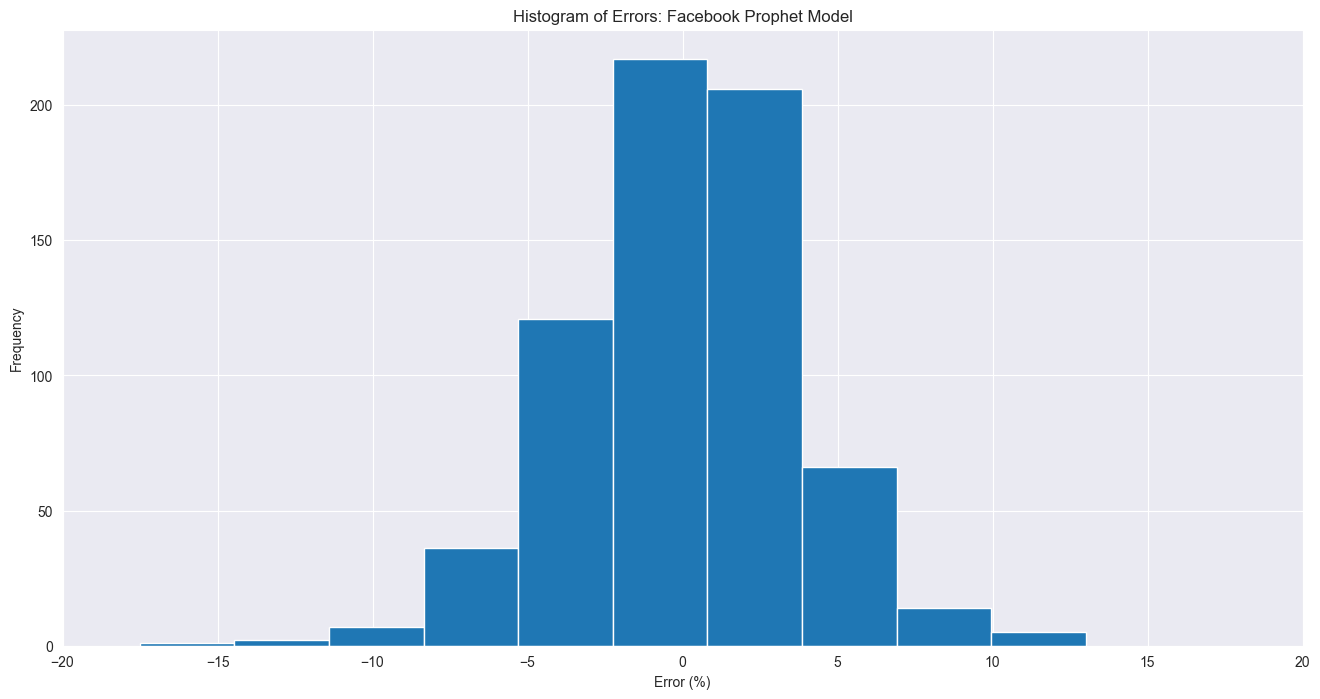

Mean absolute error of Facebook Prophet Model: 2.79 %
Correct directional forecast Facebook Prophet Model: 57.48%


In [75]:
model_name = 'Facebook Prophet Model'
errors = errors_prophet_model
errors_directional = errors_prophet_model_directional

####

plt.hist(errors)
plt.xlabel('Error (%)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Errors: {model_name}')
plt.xlim(-20, 20)
plt.show()

print(f'Mean absolute error of {model_name}: {round(np.mean(abs(pd.Series(errors))),2)} %')
print(f'Correct directional forecast {model_name}: {np.mean([1 if i > 0 else 0 for i in errors_directional])*100:.2f}%')

- Second worst MAE and worst directional forecasting

- From the testes models the regression with monthly indicator variables and lagged dependent variables performed best on MAE and direction forecating basis